# Certis Quickstart

## This notebook is a demonstration of:
- supported order types (list all of them)
- defining basic strategy (Simple Moving Average - SMA)
- downloading financial timeseries from yahoo finance
- input data format
- initialization of ExchangeInfo object (parameters that characterize given exchange,
    e.g. transaction fees)
- initialization and run of engine (combined

In [1]:
# Add parent directory to path
import sys
from typing import List

sys.path.insert(0, "..")

In [4]:
import certis

# Supported Order Types
- LIMIT
- MARKET
- STOP_MARKET
- STOP_LOSS_MARKET
- TAKE_PROFIT_MARKET

<a href="https://www.investor.gov/introduction-investing/investing-basics/how-stock-markets-work/types-orders"> order type docs for beginners

In [6]:
print(certis.OrderType.ORDERS)

['MARKET', 'LIMIT', 'STOP_MARKET', 'STOP_LOSS_MARKET', 'TAKE_PROFIT_MARKET']


# Supported Order Sides
LONG: betting for upside
SHORT: betting for downside

In [7]:
print("certis.OrderSide.LONG:", certis.OrderSide.LONG)
print("certis.OrderSide.SHORT:", certis.OrderSide.SHORT)

certis.OrderSide.LONG: 1
certis.OrderSide.SHORT: -1


# Writing Trading Strategy With Certis
- function certis.Strategy.execute() -> executes order with given data and account info
- function certis.Strategy.calculate() -> calculates indicators, etc. with given raw data

## MA Cross Strategy
- In this Tutorial, We will write a simple strategy called "MA Cross Strategy"
- BUY WHEN CLOSE > MA(CLOSE, 5)
- SELL WHEN CLOSE < MA(CLOSE, 5)

In [8]:
class MyFirstStrategy(certis.Strategy):
    def __init__(self, config):
        # config: Dict[str, Any]: config for this strategy
        # name: str: name for this strategy
        super().__init__(config, "MyFirstStrategy")
        self.ma_period = config["MA_PERIOD"]

    def calculate(self, data):
        # data: pd.DataFrame contains [open, high, low, close, volume, timestamp]
        # calculations here
        data["MA"] = data["close"].rolling(self.ma_period).mean()
        return data

    def execute(self, state_dict) -> List[certis.core.Action]:
        actions = []

        """
        state_dict example:
            {
                'has_position': 0,
                 'margin': 10000,
                 'portfolio_value': 10000.0,
                 'position': {
                     'avg_price': 0,
                     'side': 0,
                     'size': 0,
                     'unrealized_pnl': 0.0
                 },
                 'timestamp': 1579076100000000000
            }
        """

        has_position = state_dict["account_info"]["has_position"]
        portfolio_value = state_dict["account_info"]["portfolio_value"]
        position_size = state_dict["account_info"]["position"]["size"]
        data = state_dict["data"]

        if not state_dict["account_info"]["has_position"]:
            if data["close"] > data["MA"]:  # if above ma
                order = certis.Order(
                    order_type=certis.OrderType.MARKET,
                    order_quantity=portfolio_value / data["close"],  # full bet!,
                    order_side=certis.OrderSide.LONG,
                    order_price=None,  # MARKET ORDER
                    reduce_only=False,
                )
                actions.append(order)

        else:
            if data["close"] < data["MA"]:
                order = certis.Order(
                    order_type=certis.OrderType.MARKET,
                    order_quantity=position_size,  # full bet!,
                    order_side=certis.OrderSide.SHORT,
                    order_price=None,  # MARKET ORDER
                    reduce_only=True,
                )
                actions.append(order)

        return actions

# Market Info Object
- essential market info for the backtesting
- maker fee: fee for limit orders
- taker fee: fee for market orders
- slippage: slippage applied for market orders
- tick_size: tick size
- minimum_order_size: minimum order size

In [9]:
market_info = certis.ExchangeInfo(
    maker_fee=0.001,
    taker_fee=0.001,
    slippage=0.001,
    minimum_order_size=0.001,
    tick_size=0.01,
)

# Load data
Certis Supports pandas DataFrame with `[timestamp, open, high, low, close, volume]` with datetime indexes

In [10]:
from yfinance import Ticker

data = Ticker("BTC-USD").history(period="max")
data = data[data.columns[:5]]
data.columns = ["open", "high", "low", "close", "volume"]
data["timestamp"] = data.index.astype(int)
fin_data = data.copy()

# Initialize Engine
### to initialize certis backtesting engine, you need following components:
- data: pandas DataFrame
- initial margin: float
- market info: ExchangeInfo Object
- strategy: Strategy Class
- strategy config: strategy config

In [11]:
MA_WINDOW = 7
initial_margin = 100000
strategy_config = {"MA_PERIOD": MA_WINDOW}

engine = certis.Engine(
    fin_data, initial_margin, market_info, MyFirstStrategy, strategy_config
)

In [12]:
engine.run()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2838/2838 [00:00<00:00, 61407.29it/s]


# Analyzing Results
The data for analysis can be obtained from the logger.
- `engine.logger.account_infos`:  account info for timestamp-by-timestamp
- `engine.logger.transactions`:   order fill (transactions)
- `engine.logger.unfilled_order`: unfilled order for timestamp-by-timestamp

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
account_info_df = pd.DataFrame(engine.logger.account_infos)
account_info_df.index = pd.to_datetime(account_info_df["timestamp"])

## Account info from the logger in form of Data Frame

In [15]:
account_info_df.head(3)

,margin,portfolio_value,position,has_position,timestamp
timestamp,,,,,
2014-09-24,100000.000000,100000.000000,"{'size': 0, 'side': 0, 'avg_price': 0, 'unreal...",0,1.411517e+18
2014-09-25,99899.911084,96922.573678,"{'size': 229.467, 'side': 1.0, 'avg_price': 43...",1,1.411603e+18
2014-09-26,99899.911084,94253.647258,"{'size': 229.467, 'side': 1.0, 'avg_price': 43...",1,1.411690e+18


In [16]:
account_info_df.iloc[5].position

{'size': 0, 'side': 0, 'avg_price': 0, 'unrealized_pnl': 0.0}

## Plot portfolio value with matplotlib
On the plot below there is:
- portfolio value in given point of time relative to the initial portfolio value
- BTC value in given point of time relative to the initial BTC value

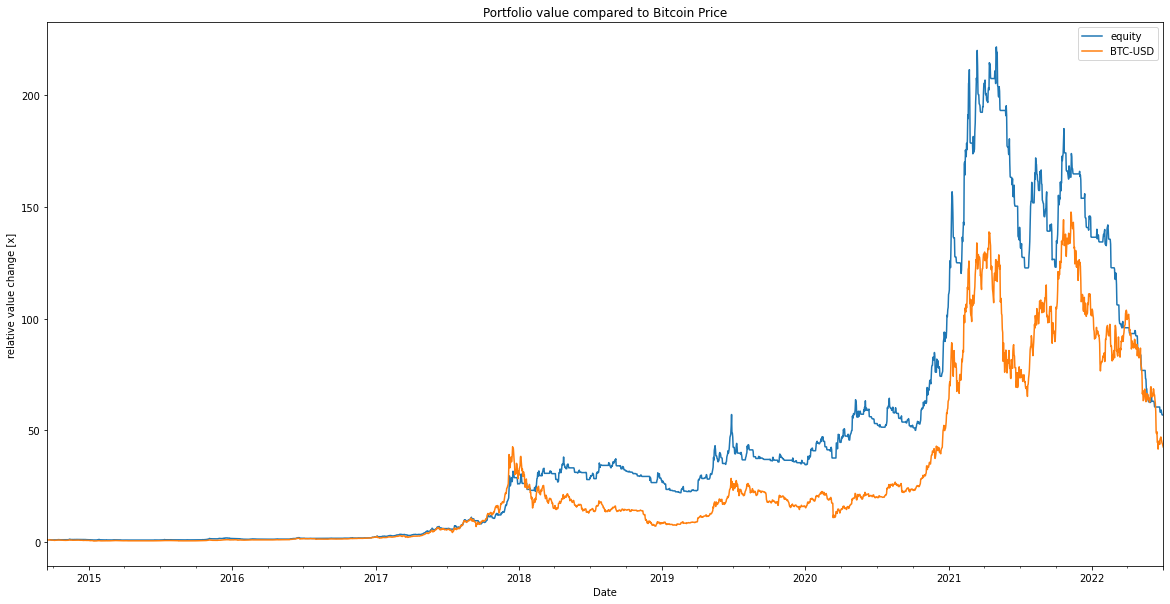

In [18]:
(account_info_df["portfolio_value"] / initial_margin).plot(
    label="equity", figsize=(20, 10)
)
ax = (fin_data["close"] / fin_data["close"][0]).plot(label="BTC-USD")
plt.legend()
_ = ax.set_title("Portfolio value compared to Bitcoin Price")
_ = ax.set_ylabel("relative value change [x]")

In [19]:
engine.logger.transactions[:2]

[{'timestamp': 1411516800000000000,
  'realized': {'pnl': 0, 'fee': 100.08891606},
  'order': {'price': 436.18,
   'quantity': 229.467,
   'side': 1,
   'type': 'MARKET'}},
 {'timestamp': 1411776000000000000,
  'realized': {'pnl': -7579.295009999994, 'fee': 92.50962105000002},
  'order': {'price': 403.15000000000003,
   'quantity': 229.467,
   'side': -1,
   'type': 'MARKET'}}]

In [20]:
transactions_df = pd.DataFrame(engine.logger.transactions)
transactions_df.index = pd.to_datetime(transactions_df["timestamp"])
transactions_df.sample(5)

,timestamp,realized,order
timestamp,,,
2022-04-01,1648771200000000000,"{'pnl': 4.326619999999996, 'fee': 0.0455086}","{'price': 45508.6, 'quantity': 0.001, 'side': ..."
2020-09-15,1600128000000000000,"{'pnl': 0, 'fee': 5330.4055484400005}","{'price': 10688.43, 'quantity': 498.708, 'side..."
2021-10-26,1635206400000000000,"{'pnl': 0, 'fee': 17436.07989597}","{'price': 63095.79, 'quantity': 276.343, 'side..."
2021-06-28,1624838400000000000,"{'pnl': 0, 'fee': 13674.598951200003}","{'price': 34713.8, 'quantity': 393.92400000000..."
2018-02-09,1518134400000000000,"{'pnl': 0, 'fee': 2315.3091985300002}","{'price': 8280.11, 'quantity': 279.623, 'side'..."


In [21]:
realized = pd.DataFrame(transactions_df.realized.to_dict()).T
order = pd.DataFrame(transactions_df.order.to_dict()).T
re_ord = realized.join(order)
tr = re_ord.join(transactions_df).drop(["realized", "order"], axis=1)
tr

,pnl,fee,price,quantity,side,type,timestamp
2014-09-24,0.00000,100.088916,436.18,229.467,1,MARKET,1411516800000000000
2014-09-27,-7579.29501,92.509621,403.15,229.467,-1,MARKET,1411776000000000000
2014-10-09,0.00000,92.269620,353.1,261.313,1,MARKET,1412812800000000000
2014-10-18,7967.40288,100.236670,383.59,261.312,-1,MARKET,1413590400000000000
2014-10-19,0.00000,100.053446,391.64,255.473,1,MARKET,1413676800000000000
...,...,...,...,...,...,...,...
2022-06-10,-1.32290,0.030080,30080.21,0.001,-1,MARKET,1654819200000000000
2022-06-22,0.00000,6051.368470,20740.13,291.771,1,MARKET,1655856000000000000
2022-06-23,-225687.78621,5825.680684,19966.62,291.771,-1,MARKET,1655942400000000000
2022-06-24,0.00000,5810.639632,21105.73,275.311,1,MARKET,1656028800000000000


## Plot buys and sells with matplotlib

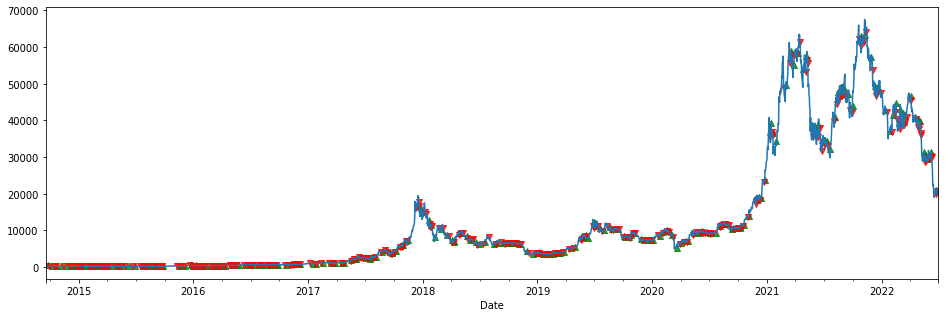

In [22]:
f, axs = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(16, 5),
)
buys = tr[tr.side == 1]
sells = tr[tr.side == -1]
price = fin_data["close"]
sma = fin_data.rolling(window=MA_WINDOW).mean().dropna()
sma = pd.DataFrame(sma["close"])
price.plot(ax=axs)
axs.scatter(buys.index, buys.price, alpha=0.8, label="Buy", marker="^", color="green")
axs.scatter(sells.index, sells.price, alpha=0.8, label="Sell", marker="v", color="red")

## Plot buys and sells with plotly

In [28]:
# Plotting
import plotly.graph_objects as go

# import plotly.io as pio
# pio.templates.default = "plotly_dark"

fig = go.Figure()

# price
k = 0.01
fig.add_trace(
    go.Scatter(
        x=fin_data.index, y=fin_data["close"], name="Close", line_color="#222222"
    )
)

# # SMA
fig.add_trace(go.Scatter(x=sma.index, y=sma["close"], name="SMA", line_color="#FECB52"))


# buy signals
fig.add_trace(
    go.Scatter(
        x=buys.index,
        y=(1 - k) * buys.price,
        name="Buys",
        mode="markers",
        marker=dict(color="#00CC96", size=10, symbol="triangle-up"),
    )
)
# sell signals
fig.add_trace(
    go.Scatter(
        x=sells.index,
        y=(1 + k) * sells.price,
        name="Sells",
        mode="markers",
        marker=dict(color="#EF553B", size=10, symbol="triangle-down"),
    )
)

fig.update_layout(
    autosize=False,
    width=960,
    height=700,
)

# Add range slider
fig.update_layout(
    xaxis=dict(rangeslider=dict(visible=True), type="date"),
    yaxis=dict(autorange=True, fixedrange=False),
)


layout = dict(
    title="Time series with range slider and selectors",
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    ),
)

# fig.show()
figu = go.FigureWidget(data=fig, layout=layout)


def zoom(layout, xrange):
    in_view = fin_data.loc[figu.layout.xaxis.range[0] : figu.layout.xaxis.range[1]]
    figu.layout.yaxis.range = [in_view.high.min() - 10, in_view.high.max() + 10]


figu.layout.on_change(zoom, "xaxis.range")
figu

FigureWidget({
    'data': [{'line': {'color': '#222222'},
              'name': 'Close',
              'type'…